In [20]:
import sys
import os
import json
import joblib
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from collections import deque
from tqdm.notebook import tqdm

# ==========================================
# 1. PATH SETUP
# ==========================================
# Assumes the notebook is located in a 'notebooks' subfolder.
# We resolve '..' to get the Project Root.
# If running from the root, change to Path('.')
PROJECT_ROOT = Path('..').resolve()

# Add project root to system path to allow imports from 'src'
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

# ==========================================
# 2. LOCAL IMPORTS
# ==========================================
try:
    from src.utils_physics import preprocess_trajectory, compute_physics_features
    from src.utils_ml import compute_features, prepare_inference_window, apply_nms
    print("Imports from src/ successful!")
except ImportError as e:
    print(f"Import Error: {e}")
    print(f"Ensure that 'src' exists at: {PROJECT_ROOT}")

# ==========================================
# 3. DATA CONFIGURATION
# ==========================================
DATA_DIR = PROJECT_ROOT / "input_data/per_point_v2"
VIDEO_SOURCE = PROJECT_ROOT / "input_data/Alcaraz_Sinner_2025.mp4"
MODEL_PATH = PROJECT_ROOT / "tennis_xgb_supervised.pkl"

# Status Check
print(f"Data Directory found: {DATA_DIR.exists()}")
print(f"Video Source found:   {VIDEO_SOURCE.exists()}")
print(f"Model File found:     {MODEL_PATH.exists()}")

# ==========================================
# 4. VISUALIZATION SETTINGS
# ==========================================
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
FPS = 50

Imports from src/ successful!
Data Directory found: True
Video Source found:   True
Model File found:     True


In [17]:
all_points = []
files = sorted(list(DATA_DIR.glob("ball_data_*.json")))

print(f"Loading {len(files)} points...")

for file in tqdm(files):
    with open(file) as f:
        point_data = json.load(f)
        point_id = int(file.stem.split("_")[-1])
        
        # Basic Stats Extraction
        frames = [int(k) for k in point_data.keys()]
        # Using .get() for safety in case 'action' or 'visible' keys are missing
        actions = [v.get("action", "air") for v in point_data.values()]
        visible = [v.get("visible", False) for v in point_data.values()]
        
        # Count explicit 'air' labels, or calculate later if they are None/Missing
        n_hit = actions.count("hit")
        n_bounce = actions.count("bounce")
        # Assuming anything not hit/bounce is air (if labeled 'air' or None)
        n_air = len(frames) - n_hit - n_bounce 
        
        all_points.append({
            "point_id": point_id,
            "n_frames": len(frames),
            "n_visible": sum(visible),
            "n_hit": n_hit,
            "n_bounce": n_bounce,
            "n_air": n_air
        })

df_stats = pd.DataFrame(all_points)

print("\n=== GLOBAL STATISTICS ===")
print(f"Total Points     : {len(df_stats)}")
print(f"Avg Duration     : {df_stats['n_frames'].mean():.1f} ± {df_stats['n_frames'].std():.1f} frames")
print(f"Visibility       : {(df_stats['n_visible'].sum() / df_stats['n_frames'].sum())*100:.1f}%")

print("\n=== CLASS DISTRIBUTION ===")
total_frames = df_stats['n_frames'].sum()
print(f"Air    : {df_stats['n_air'].sum()} ({df_stats['n_air'].sum()/total_frames*100:.2f}%)")
print(f"Hit    : {df_stats['n_hit'].sum()} ({df_stats['n_hit'].sum()/total_frames*100:.2f}%)")
print(f"Bounce : {df_stats['n_bounce'].sum()} ({df_stats['n_bounce'].sum()/total_frames*100:.2f}%)")

Loading 313 points...


  0%|          | 0/313 [00:00<?, ?it/s]


=== GLOBAL STATISTICS ===
Total Points     : 313
Avg Duration     : 566.6 ± 336.3 frames
Visibility       : 64.1%

=== CLASS DISTRIBUTION ===
Air    : 174295 (98.28%)
Hit    : 1600 (0.90%)
Bounce : 1446 (0.82%)


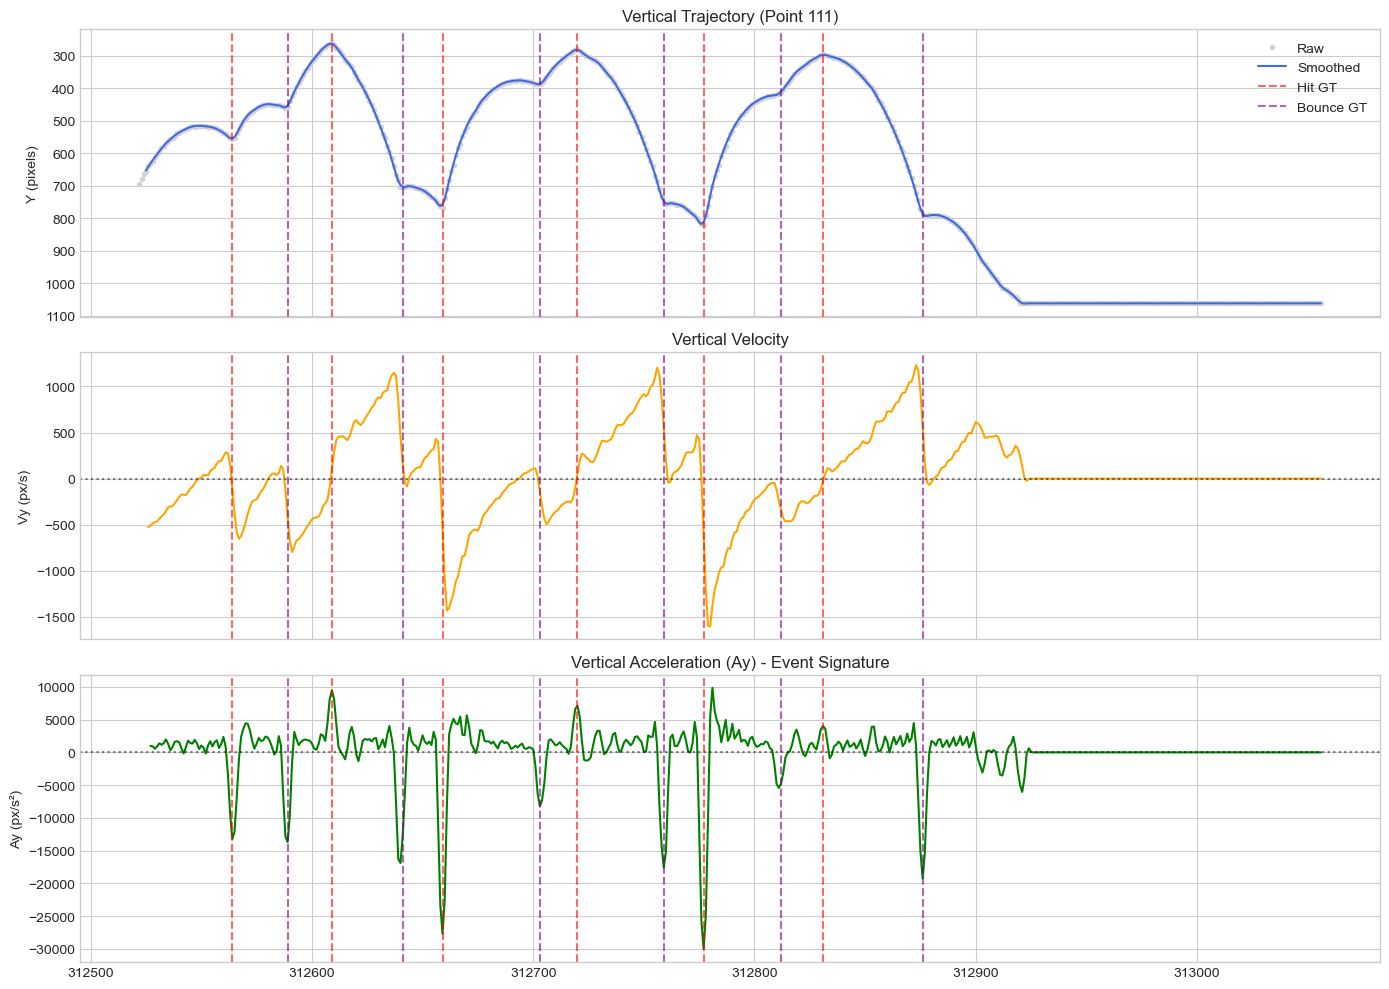

In [18]:
# Select point to visualize
POINT_ID = 111  # Change ID here (e.g., 111, 308, 102)
json_path = DATA_DIR / f"ball_data_{POINT_ID}.json"

if json_path.exists():
    with open(json_path) as f:
        data = json.load(f)
    
    # Computation
    df = preprocess_trajectory(data)
    df = compute_physics_features(df, fps=FPS)
    
    # Ground Truth Extraction
    hits = df[df['action'] == 'hit'].index
    bounces = df[df['action'] == 'bounce'].index
    
    # Plotting
    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
    
    # 1. Y Position
    axes[0].plot(df.index, df['y'], '.', color='lightgray', label='Raw')
    axes[0].plot(df.index, df['y_smooth'], '-', color='royalblue', label='Smoothed')
    axes[0].set_ylabel("Y (pixels)")
    axes[0].set_title(f"Vertical Trajectory (Point {POINT_ID})")
    axes[0].invert_yaxis() # Tennis: 0 is top
    axes[0].legend(loc='upper right')
    
    # 2. Vertical Velocity
    axes[1].plot(df.index, df['vy'], '-', color='orange', label='Vy')
    axes[1].axhline(0, color='black', linestyle=':', alpha=0.5)
    axes[1].set_ylabel("Vy (px/s)")
    axes[1].set_title("Vertical Velocity")
    
    # 3. Vertical Acceleration (The Physics Signature)
    axes[2].plot(df.index, df['ay'], '-', color='green', label='Ay')
    axes[2].axhline(0, color='black', linestyle=':', alpha=0.5)
    axes[2].set_ylabel("Ay (px/s²)")
    axes[2].set_title("Vertical Acceleration (Ay) - Event Signature")
    
    # Mark events on all subplots
    for ax in axes:
        for hit in hits:
            ax.axvline(hit, color='red', linestyle='--', alpha=0.6, label='Hit GT' if hit==hits[0] and ax==axes[0] else "")
        for bounce in bounces:
            ax.axvline(bounce, color='purple', linestyle='--', alpha=0.6, label='Bounce GT' if bounce==bounces[0] and ax==axes[0] else "")
            
    # Unified legend on the first plot
    handles, labels = axes[0].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    axes[0].legend(by_label.values(), by_label.keys(), loc='upper right')

    plt.tight_layout()
    plt.show()
else:
    print(f"File not found: {json_path}")

Audit Missed Events on 313 files...


  0%|          | 0/313 [00:00<?, ?it/s]

Analysis successful on 3046 events.


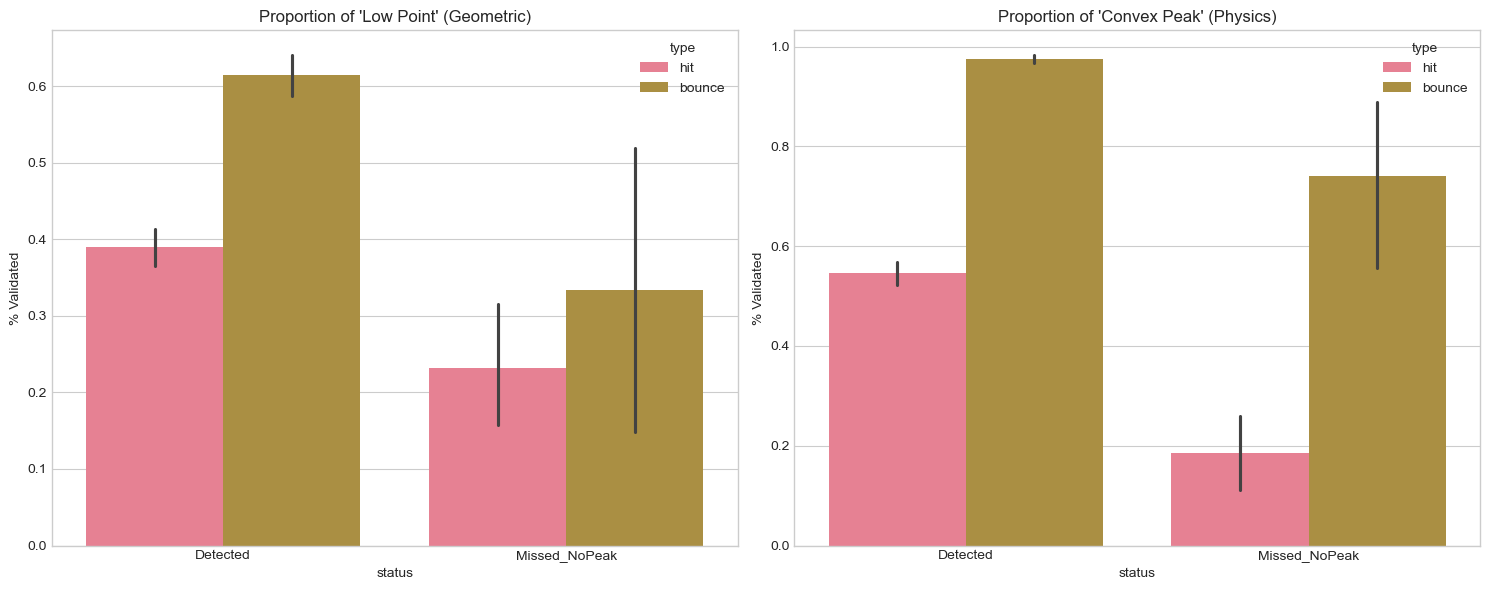

In [19]:
# --- DIAGNOSTIC TOOL ---
def analyze_missed_events(data_directory):
    data_path = Path(data_directory)
    files = sorted(list(data_path.glob("ball_data_*.json")))
    print(f"Audit Missed Events on {len(files)} files...")
    
    audit_data = []
    error_count = 0
    
    for file in tqdm(files):
        try:
            with open(file, 'r') as f:
                data = json.load(f)
            
            # 1. Skip empty files
            if not data: 
                continue

            # Use imported function from src
            df = preprocess_trajectory(data)
            
            # 2. Check data length
            if len(df) < 5:
                continue
                
            # Use imported function from src
            df = compute_physics_features(df, fps=50)
            
            # Naive detection simulation (Ay peaks)
            # Ensure 'ay' exists (fill NaN just in case)
            if 'ay' not in df.columns: continue
            
            df['ay'] = df['ay'].fillna(0)
            df['ay_abs'] = df['ay'].abs()
            peaks, _ = find_peaks(df['ay_abs'], height=2000, prominence=1000, distance=10)
            
            # Ground Truth Comparison
            if 'action' in df.columns:
                gt_indices = df[df['action'].isin(['hit', 'bounce'])].index
                
                for gt in gt_indices:
                    label = df.loc[gt, 'action']
                    
                    # Is there a peak detected nearby?
                    matches = [p for p in peaks if abs(df.index[p] - gt) <= 5]
                    status = "Detected" if matches else "Missed_NoPeak"
                    
                    # Physics Feature
                    ay = abs(df.loc[gt, 'ay'])
                    
                    # --- GEOMETRY SAFETY CHECK ---
                    # Use index position (iloc) rather than label (loc) to avoid KeyErrors
                    if gt in df.index:
                        idx_pos = df.index.get_loc(gt)
                        
                        # Handle edges (start/end of video)
                        start = max(0, idx_pos - 5)
                        end = min(len(df), idx_pos + 6)
                        
                        local_y = df['y'].iloc[start:end]
                        
                        if not local_y.empty:
                            # Inverted Y: higher value = lower on screen
                            is_low_point = df.iloc[idx_pos]['y'] >= (local_y.max() - 5)
                        else:
                            is_low_point = False
                        
                        # Convexity (Negative acceleration peak = upward shock)
                        convexity = (df.loc[gt, 'ay'] < 0)
                        
                        audit_data.append({
                            'type': label,
                            'status': status,
                            'ay': ay,
                            'is_low_point': is_low_point,
                            'is_convex_peak': convexity
                        })
                
        except Exception as e:
            # Print only the FIRST error to debug, then continue silently
            if error_count == 0:
                print(f"Error on {file.name} : {e}")
            error_count += 1
            continue
    
    if error_count > 0:
        print(f"{error_count} files ignored due to errors.")

    # Return empty DataFrame if no data found to avoid crashes
    if not audit_data:
        return pd.DataFrame(columns=['type', 'status', 'ay', 'is_low_point', 'is_convex_peak'])
            
    return pd.DataFrame(audit_data)

# --- EXECUTION ---
# Assumes DATA_DIR is defined in previous cells
df_audit = analyze_missed_events(DATA_DIR)

# --- VISUALIZATION ---
if df_audit.empty:
    print("No data extracted. Check the error displayed above.")
else:
    print(f"Analysis successful on {len(df_audit)} events.")
    plt.figure(figsize=(15, 6))

    # 1. Low Point
    plt.subplot(1, 2, 1)
    sns.barplot(x='status', y='is_low_point', hue='type', data=df_audit)
    plt.title("Proportion of 'Low Point' (Geometric)")
    plt.ylabel("% Validated")

    # 2. Convexity
    plt.subplot(1, 2, 2)
    sns.barplot(x='status', y='is_convex_peak', hue='type', data=df_audit)
    plt.title("Proportion of 'Convex Peak' (Physics)")
    plt.ylabel("% Validated")

    plt.tight_layout()
    plt.show()

In [23]:
# ==========================================
# 1. PREDICTION PIPELINE
# ==========================================

def predict_point_logic(point_data, model, window_size=5):
    """
    Full Pipeline: JSON -> Preprocess -> Features -> Windowing -> Predict -> NMS.
    """
    # 1. Preprocessing (JSON to DataFrame, Interpolation)
    df = preprocess_trajectory(point_data)
    
    # 2. Feature Engineering (Physics)
    df = compute_features(df, fps=50)
    
    # 3. Prepare Input Matrix (Windowing)
    X = prepare_inference_window(df, window_size=window_size)
    
    # 4. Model Prediction
    probs = model.predict_proba(X)
    
    # 5. Post-Processing (Non-Maximum Suppression)
    preds = apply_nms(probs, threshold_hit=0.60, threshold_bounce=0.60, refractory=10)
    
    # 6. Format Output
    pred_dict = {}
    frame_ids = df.index.values
    for i, p in enumerate(preds):
        if p == 1: pred_dict[frame_ids[i]] = 'bounce'
        if p == 2: pred_dict[frame_ids[i]] = 'hit'
            
    return pred_dict

# ==========================================
# 2. VIDEO PROCESSING FUNCTIONS
# ==========================================

def extract_subvideo(video_path, start_frame, end_frame, temp_output="temp_clip.mp4"):
    cap = cv2.VideoCapture(str(video_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    out = cv2.VideoWriter(str(temp_output), cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)
    
    # Extract frames
    count = 0
    total_frames = end_frame - start_frame + 1
    while count < total_frames:
        ret, frame = cap.read()
        if not ret: break
        out.write(frame)
        count += 1
        
    cap.release()
    out.release()
    return temp_output

def create_comparison_video(clip_path, point_data, pred_dict, output_video_path):
    cap = cv2.VideoCapture(str(clip_path))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    out = cv2.VideoWriter(str(output_video_path), cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    # Prepare Visualization Data
    df = pd.DataFrame.from_dict(point_data, orient='index')
    df.index = df.index.astype(int)
    # Visual interpolation for smoothness
    df[['x', 'y']] = df[['x', 'y']].astype(float).interpolate(limit_direction='both')
    
    start_frame_global = df.index.min()
    current_frame_idx = 0
    ball_tail = deque(maxlen=int(1.0 * fps))
    events_display_buffer = [] 
    
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret: break
        
        global_frame = start_frame_global + current_frame_idx
        
        # Draw Ball and Tail
        if global_frame in df.index:
            row = df.loc[global_frame]
            x, y = int(row['x']), int(row['y'])
            ball_tail.append((x, y))
            
            for i in range(1, len(ball_tail)):
                cv2.line(frame, ball_tail[i-1], ball_tail[i], (0, 255, 255), 2)
            cv2.circle(frame, (x, y), 5, (0, 255, 255), -1)

            # Check Events (Ground Truth vs Prediction)
            gt_action = point_data.get(str(global_frame), {}).get('action', 'air')
            pred_action = pred_dict.get(global_frame, 'air')
            
            if gt_action != 'air':
                events_display_buffer.append({'type': 'GT', 'action': gt_action, 'pos': (x, y), 'life': 20})
            if pred_action != 'air':
                # Offset prediction slightly to be visible
                events_display_buffer.append({'type': 'IA', 'action': pred_action, 'pos': (x+15, y-15), 'life': 20})
        
        # Draw Persistent Events
        new_buffer = []
        for event in events_display_buffer:
            x, y = event['pos']
            color = (255, 0, 0) if event['type'] == 'GT' else (0, 0, 255)
            label = event['type']
            
            if event['action'] == 'bounce':
                cv2.circle(frame, (x, y), 20, color, 2)
                cv2.putText(frame, f"{label}:Bounce", (x-30, y-25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            elif event['action'] == 'hit':
                cv2.line(frame, (x-15, y-15), (x+15, y+15), color, 3)
                cv2.line(frame, (x-15, y+15), (x+15, y-15), color, 3)
                cv2.putText(frame, f"{label}:Hit", (x-30, y-25), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            
            event['life'] -= 1
            if event['life'] > 0: new_buffer.append(event)
        events_display_buffer = new_buffer
        
        # Legend
        cv2.putText(frame, "Blue: Ground Truth", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 0), 2)
        cv2.putText(frame, "Red: AI Model", (10, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        out.write(frame)
        current_frame_idx += 1
        
    cap.release()
    out.release()
    print(f"Comparison video generated: {output_video_path}")

# ==========================================
# 3. EXECUTION
# ==========================================

POINT_ID_TO_TEST = 102

if not MODEL_PATH.exists():
    print(f"Error: Model not found at {MODEL_PATH}")
else:
    print(f"Loading model: {MODEL_PATH.name}")
    model = joblib.load(MODEL_PATH)
    
    # Load point data
    json_path = DATA_DIR / f"ball_data_{POINT_ID_TO_TEST}.json"
    
    if not json_path.exists():
        print(f"Error: JSON not found: {json_path}")
    else:
        print(f"Processing point {POINT_ID_TO_TEST}...")
        with open(json_path, 'r') as f:
            point_data = json.load(f)
        
        # Predict
        pred_dict = predict_point_logic(point_data, model)
        
        n_bounce = list(pred_dict.values()).count('bounce')
        n_hit = list(pred_dict.values()).count('hit')
        print(f"Stats: {n_bounce} bounces, {n_hit} hits detected.")
        
        # Video Pipeline
        df = pd.DataFrame.from_dict(point_data, orient='index')
        df.index = df.index.astype(int)
        start_f, end_f = df.index.min(), df.index.max()
        
        temp_clip = PROJECT_ROOT / "temp_raw_clip.mp4"
        print("Extracting source video clip...")
        extract_subvideo(VIDEO_SOURCE, start_f, end_f, temp_output=temp_clip)
        
        output_name = PROJECT_ROOT / f"result_point_{POINT_ID_TO_TEST}_comparison.mp4"
        print("Generating overlay...")
        create_comparison_video(temp_clip, point_data, pred_dict, output_name)
        
        # Cleanup
        if temp_clip.exists():
            os.remove(temp_clip)

Loading model: tennis_xgb_supervised.pkl
Processing point 102...
Stats: 7 bounces, 7 hits detected.
Extracting source video clip...
Generating overlay...
Comparison video generated: /Users/hugo.niedzielski/Documents/PFE/quantum_analytics/tennis_hit_bounce/result_point_102_comparison.mp4
